In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.mixture import GaussianMixture

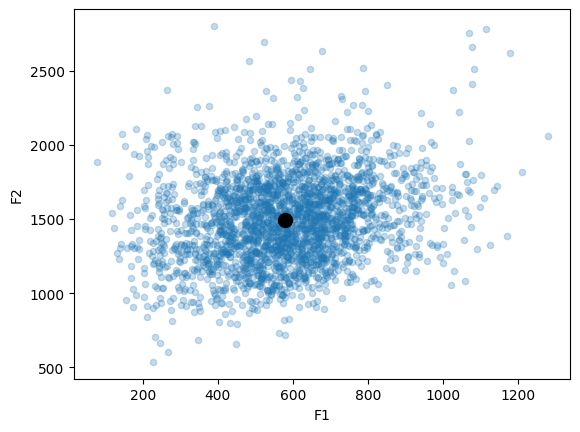

In [2]:
# フォルマント推定結果が保存された CSV ファイルを読み込む
# 各行は 1 フレーム（または 1 サンプル）に対応し，
# 少なくとも「Vowel」「F1」「F2」列を持つことを想定している
dfFormant = pd.read_csv("FormantCVTrainShort.csv")

# 母音が「あ」に相当するサンプルだけを抽出し（Vowel=="a"），
# 第1フォルマント F1 を x 軸，第2フォルマント F2 を y 軸として散布図を描く
# alpha=0.25 により点を半透明にして，サンプルの密度が視覚的に分かりやすくなっている
dfFormant.query('Vowel=="a"').plot.scatter(x="F1", y="F2", alpha=0.25)

# 同じく「あ」のサンプルに絞ったうえで，F1 と F2 の平均値（重心）を計算する
# [['F1','F2']] で F1,F2 の2列だけを取り出し，mean() で列ごとの平均値を計算
# to_numpy() で (F1_mean, F2_mean) という形の NumPy 配列に変換している
mean_F1_F2 = dfFormant.query('Vowel=="a"')[["F1", "F2"]].mean().to_numpy()

# 平均フォルマント位置（クラス「a」の代表点）を黒丸 ('ok') でプロットする
# *mean_F1_F2 により，(x, y) = (F1_mean, F2_mean) として渡される
# markersize=10 で周囲の散布点よりも大きく目立たせている
plt.plot(*mean_F1_F2, "ok", markersize=10)

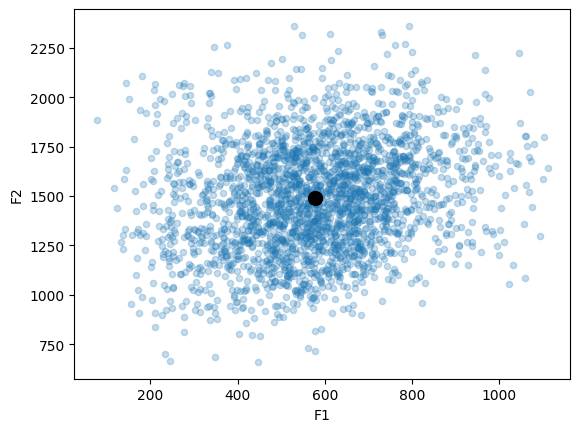

In [3]:
plt.close()

# 各母音クラスごとに F1, F2 の外れ値度合い（zスコア）を計算するためのループ
# dfFormant['Vowel'].unique() で，CSV に含まれるすべての母音ラベルを列挙する
for v in dfFormant["Vowel"].unique():
    # その母音 v に属する行インデックスだけを取り出す
    i = dfFormant.query(f'Vowel=="{v}"').index

    # 第1フォルマント F1 について，母音 v のサンプル内での z スコアを計算し，
    # その絶対値を zF1 列に格納する
    # → 各母音ごとに「平均から何標準偏差だけ離れているか」を測っている
    dfFormant.loc[i, "zF1"] = np.abs(stats.zscore(dfFormant.loc[i, "F1"]))

    # 第2フォルマント F2 についても同様に z スコアの絶対値を計算し，zF2 列に格納する
    dfFormant.loc[i, "zF2"] = np.abs(stats.zscore(dfFormant.loc[i, "F2"]))

# zF1, zF2 の両方が 3 未満（≒ 平均±3σ 以内）にある「あ」のサンプルだけを抽出
# → F1, F2 が極端に外れたフレームを除外することで，
#   クラス "a" のフォルマント分布をより「代表的な」サンプルに限定する
dfA = dfFormant.query('zF1 < 3 & zF2 < 3 & Vowel=="a"')

# 外れ値を除いた「あ」のサンプルに対して，F1–F2 平面上の散布図を描画
# alpha=0.25 で半透明にして，サンプル密度の高い領域が視覚的に分かりやすくなる
dfA.plot.scatter(x="F1", y="F2", alpha=0.25)

# 外れ値除去後の F1, F2 の平均値（クラス "a" の代表点）を計算して描画
# [['F1','F2']].mean().to_numpy() で (mean_F1, mean_F2) の形に変換し，
# plt.plot(*...) で (x, y) 座標として渡している
# 'ok' は黒丸マーカー，markersize=10 で散布点よりも目立つようにしている
plt.plot(*(dfA[["F1", "F2"]].mean().to_numpy()), "ok", markersize=10)